# Louvain

In [8]:
import ast
import collections
import json
import math
import os
import re
import time
from collections import Counter, defaultdict

import community as community_louvain
import igraph as ig
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from dotenv import find_dotenv, load_dotenv
from infomap import Infomap
from networkx.algorithms.cuts import conductance

* **Louvain** is a **community detection algorithm** introduced by Blondel et al. (2008).
* Instead of focusing on information flow (like Infomap), it optimizes **modularity**:

  * Modularity measures how well a partition separates a network into dense **intra-community connections** with sparse **inter-community connections**.
  * A high modularity means that most edges fall inside communities rather than between them.
  * Louvain’s goal: find the partition that **maximizes modularity**.

---

**Key Features**

* **Fast & Scalable**: Works on graphs with **millions of nodes and edges**.
* **Hierarchical**: Builds a hierarchy of communities (coarse → fine).
* **Unsupervised**: No prior knowledge of number or size of communities required.
* **Widely used**: Standard baseline for community detection in network science.

---

**How It Works (Conceptually)**

1. **Local Modularity Optimization**

   * Start with each node in its own community.
   * For each node, check if moving it to a neighbor’s community **increases modularity**.
   * Move the node if beneficial; repeat until no single-node move improves modularity.

2. **Community Aggregation**

   * Collapse the graph: each community becomes a “super-node.”
   * Edges between communities are weighted by total connections.

3. **Iterative Refinement**

   * Repeat steps 1–2 until modularity gain is negligible.
   * The result is a hierarchy: fine-grained communities at lower levels, coarse ones at higher levels.

---

* *“Where are the edges densest relative to chance?”*
* That density = a community.

---


## Dataset NQ version 0

In [2]:
def create_test_graph():
    """Create test graph with metadata."""
    # Load dataset
    df = pd.read_csv("../data/v0.0/df_nq_version0.csv")

    # Convert stringified lists into real Python lists
    df["cites_ids"] = df["cites_ids"].apply(ast.literal_eval)

    # Create a directed graph
    G = nx.DiGraph()

    # Add edges to the graph
    for _, row in df.iterrows():
        src = row["id"]
        G.add_node(src, title=row["d_properties_document_title"])
        for tgt in row["cites_ids"]:
            G.add_edge(src, tgt)

    # Graph metadata for reporting
    graph_info = {
        "source": "NQ (Natural Questions) from Google",
        "description": "Graph constructed from wiki articles citation data in the Natural Questions dataset"
    }

    return G, graph_info

G, graph_info = create_test_graph()

## Implementation

In [3]:
# Let's implement Louvain using multiple popular libraries
print("Graph Statistics:")
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")
print(f"Is directed: {G.is_directed()}")
print(f"Is connected: {nx.is_weakly_connected(G) if G.is_directed() else nx.is_connected(G)}")

Graph Statistics:
Nodes: 108071
Edges: 5122983
Is directed: True
Is connected: False


In [4]:
isolated_nodes = [n for n, d in G.degree() if d == 0]
G.remove_nodes_from(isolated_nodes)
print("Graph Statistics after removal:")
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")

Graph Statistics after removal:
Nodes: 107536
Edges: 5122983


In [5]:
# Convert to undirected for most community detection algorithms
G_undirected_1 = G.to_undirected()
print(f"Undirected graph - Nodes: {G_undirected_1.number_of_nodes()}, Edges: {G_undirected_1.number_of_edges()}")

Undirected graph - Nodes: 107536, Edges: 4372291


In [5]:
# Create undirected graph with edge weights reflecting bidirectional citations
G_undirected_2 = nx.Graph()
for u, v in G.edges():
    if G_undirected_2.has_edge(u, v):
        # Already added from the other direction, increment weight
        G_undirected_2[u][v]['weight'] += 1
    elif G_undirected_2.has_edge(v, u):
        # Already added from the other direction, increment weight
        G_undirected_2[v][u]['weight'] += 1
    else:
        # Add edge with initial weight 1
        G_undirected_2.add_edge(u, v, weight=1)

print(f"Undirected graph with weights - Nodes: {G_undirected_2.number_of_nodes()}, Edges: {G_undirected_2.number_of_edges()}")

# Extract all weights
weights = [d['weight'] for _, _, d in G_undirected_2.edges(data=True)]
weight_counts = Counter(weights)
for w, count in sorted(weight_counts.items()):
    print(f"Weight {w}: {count} edges")

Undirected graph with weights - Nodes: 107536, Edges: 4372291
Weight 1: 3621599 edges
Weight 2: 750692 edges


In [28]:

G_CRU, _ = create_test_graph()

G_CRU = G_CRU.to_undirected()

# Run Louvain with default parameters
print("=== Python-Louvain Implementation ===")
partition_louvain_gteste, mod_louvain_gteste, metrics_louvain_gteste = louvain_community_detection(G_CRU)

print(f"Modularity: {mod_louvain_gteste:.4f}")
print(f"Number of communities: {metrics_louvain_gteste['num_communities']}")
print(f"Execution time: {metrics_louvain_gteste['execution_time']:.4f} seconds")
print(f"Community size stats: min={metrics_louvain_gteste['smallest_community']}, "
      f"max={metrics_louvain_gteste['largest_community']}, "
      f"avg={metrics_louvain_gteste['avg_community_size']:.1f}")

=== Python-Louvain Implementation ===
Modularity: 0.5681
Number of communities: 553
Execution time: 269.5952 seconds
Community size stats: min=1, max=21642, avg=195.4


### Implementation 1: python-louvain (community) Library

**Overview**: The most popular and widely-used implementation of the Louvain algorithm.

**Key Features**:
- Fast and memory-efficient
- Direct modularity optimization
- Hierarchical community detection
- Well-tested and stable

**Parameters**:
- `resolution`: Controls community size (default=1.0)
  - Higher values → smaller communities
  - Lower values → larger communities
- `randomize`: Whether to randomize node order (affects reproducibility)
- `random_state`: For reproducible results

In [ ]:
def louvain_community_detection(graph, resolution=1.0, random_state=42):
    """
    Detect communities using python-louvain library.
    
    Parameters:
    - resolution: Controls community granularity (default=1.0)
    - random_state: For reproducible results
    
    Returns:
    - communities: dict {node: community_id}
    - modularity: modularity score
    - metrics: additional metrics
    """
    start_time = time.time()
    
    # Detect communities
    partition = community_louvain.best_partition(
        graph, 
        resolution=resolution, 
        random_state=random_state
    )
    
    # Calculate modularity
    modularity = community_louvain.modularity(partition, graph)
    
    # Calculate additional metrics
    communities_dict = defaultdict(list)
    for node, comm_id in partition.items():
        communities_dict[comm_id].append(node)
    
    community_sizes = [len(nodes) for nodes in communities_dict.values()]
    
    execution_time = time.time() - start_time
    
    metrics = {
        'algorithm': 'python-louvain',
        'num_communities': len(communities_dict),
        'modularity': modularity,
        'largest_community': max(community_sizes),
        'smallest_community': min(community_sizes),
        'avg_community_size': np.mean(community_sizes),
        'std_community_size': np.std(community_sizes),
        'execution_time': execution_time
    }
    
    return partition, modularity, metrics

In [8]:
# Run Louvain with default parameters
print("=== Python-Louvain Implementation ===")
partition_louvain_g1, mod_louvain_g1, metrics_louvain_g1 = louvain_community_detection(G_undirected_1)

print(f"Modularity: {mod_louvain_g1:.4f}")
print(f"Number of communities: {metrics_louvain_g1['num_communities']}")
print(f"Execution time: {metrics_louvain_g1['execution_time']:.4f} seconds")
print(f"Community size stats: min={metrics_louvain_g1['smallest_community']}, "
      f"max={metrics_louvain_g1['largest_community']}, "
      f"avg={metrics_louvain_g1['avg_community_size']:.1f}")

# Test different resolution parameters
print("\n--- Resolution Parameter Analysis ---")
resolutions = [0.5, 1.0, 1.5, 2.0]
for res in resolutions:
    partition_res, mod_res, metrics_res = louvain_community_detection(G_undirected_1, resolution=res)
    print(f"Resolution {res}: {metrics_res['num_communities']} communities, "
          f"modularity {mod_res:.4f}")

# Store results for comparison
results_comparison = {'python-louvain_g1': metrics_louvain_g1}

=== Python-Louvain Implementation ===
Modularity: 0.5649
Number of communities: 18
Execution time: 211.5263 seconds
Community size stats: min=2, max=20006, avg=5974.2

--- Resolution Parameter Analysis ---
Resolution 0.5: 201 communities, modularity 0.4935
Resolution 1.0: 18 communities, modularity 0.5649
Resolution 1.5: 33 communities, modularity 0.5550
Resolution 2.0: 47 communities, modularity 0.5446


In [9]:

# Run Louvain with default parameters
print("=== Python-Louvain Implementation ===")
partition_louvain_g2, mod_louvain_g2, metrics_louvain_g2 = louvain_community_detection(G_undirected_2)

print(f"Modularity: {mod_louvain_g2:.4f}")
print(f"Number of communities: {metrics_louvain_g2['num_communities']}")
print(f"Execution time: {metrics_louvain_g2['execution_time']:.4f} seconds")
print(f"Community size stats: min={metrics_louvain_g2['smallest_community']}, "
      f"max={metrics_louvain_g2['largest_community']}, "
      f"avg={metrics_louvain_g2['avg_community_size']:.1f}")

# Test different resolution parameters
print("\n--- Resolution Parameter Analysis ---")
resolutions = [0.5, 1.0, 1.5, 2.0]
for res in resolutions:
    partition_res, mod_res, metrics_res = louvain_community_detection(G_undirected_2, resolution=res)
    print(f"Resolution {res}: {metrics_res['num_communities']} communities, "
          f"modularity {mod_res:.4f}")

results_comparison = {'python-louvain_g2': metrics_louvain_g2}

=== Python-Louvain Implementation ===
Modularity: 0.5981
Number of communities: 25
Execution time: 318.0495 seconds
Community size stats: min=2, max=19203, avg=4301.4

--- Resolution Parameter Analysis ---
Resolution 0.5: 401 communities, modularity 0.5552
Resolution 1.0: 25 communities, modularity 0.5981
Resolution 1.5: 37 communities, modularity 0.5894
Resolution 2.0: 41 communities, modularity 0.5752


In [21]:
results_comparison['python-louvain_g1'] = metrics_louvain_g1

### Implementation 2: NetworkX Louvain

**Overview**: NetworkX's built-in implementation of the Louvain algorithm (available since v2.5).

**Key Features**:
- Integrated with NetworkX ecosystem
- Consistent API with other NetworkX algorithms
- Good for smaller to medium graphs
- Returns communities as sets (different format)

**Parameters**:
- `resolution`: Controls community granularity
- `threshold`: Minimum modularity gain threshold
- `seed`: For reproducible results
- `weight`: Edge weight attribute to use

In [6]:
def networkx_louvain_detection(graph, resolution=1.0, threshold=1e-07, seed=42):
    """
    Detect communities using NetworkX's Louvain implementation.
    
    Parameters:
    - resolution: Controls community granularity
    - threshold: Minimum modularity gain to continue
    - seed: For reproducible results
    
    Returns:
    - communities: list of sets (each set is a community)
    - modularity: modularity score
    - metrics: additional metrics
    """
    start_time = time.time()
    
    # Detect communities (returns list of sets)
    communities = nx.community.louvain_communities(
        graph, 
        resolution=resolution, 
        threshold=threshold, 
        seed=seed
    )
    
    # Convert to partition format for consistency
    partition = {}
    for comm_id, nodes in enumerate(communities):
        for node in nodes:
            partition[node] = comm_id
    
    # Calculate modularity
    modularity = nx.community.modularity(graph, communities)
    
    # Calculate metrics
    community_sizes = [len(comm) for comm in communities]
    execution_time = time.time() - start_time
    
    metrics = {
        'algorithm': 'networkx-louvain',
        'num_communities': len(communities),
        'modularity': modularity,
        'largest_community': max(community_sizes) if community_sizes else 0,
        'smallest_community': min(community_sizes) if community_sizes else 0,
        'avg_community_size': np.mean(community_sizes) if community_sizes else 0,
        'std_community_size': np.std(community_sizes) if community_sizes else 0,
        'execution_time': execution_time
    }
    
    return communities, partition, modularity, metrics

In [11]:
# Run NetworkX Louvain
print("=== NetworkX Louvain Implementation ===")
communities_nx_g1, partition_nx_g1, mod_nx_g1, metrics_nx_g1 = networkx_louvain_detection(G_undirected_1)

print(f"Modularity: {mod_nx_g1:.4f}")
print(f"Number of communities: {metrics_nx_g1['num_communities']}")
print(f"Execution time: {metrics_nx_g1['execution_time']:.4f} seconds")
print(f"Community size stats: min={metrics_nx_g1['smallest_community']}, "
      f"max={metrics_nx_g1['largest_community']}, "
      f"avg={metrics_nx_g1['avg_community_size']:.1f}")

# Store results
results_comparison['networkx-louvain_g1'] = metrics_nx_g1

=== NetworkX Louvain Implementation ===
Modularity: 0.5664
Number of communities: 21
Execution time: 95.4724 seconds
Community size stats: min=2, max=20833, avg=5120.8


In [12]:
# Run NetworkX Louvain
print("=== NetworkX Louvain Implementation ===")
communities_nx_g2, partition_nx_g2, mod_nx_g2, metrics_nx_g2 = networkx_louvain_detection(G_undirected_2)

print(f"Modularity: {mod_nx_g2:.4f}")
print(f"Number of communities: {metrics_nx_g2['num_communities']}")
print(f"Execution time: {metrics_nx_g2['execution_time']:.4f} seconds")
print(f"Community size stats: min={metrics_nx_g2['smallest_community']}, "
      f"max={metrics_nx_g2['largest_community']}, "
      f"avg={metrics_nx_g2['avg_community_size']:.1f}")

# Store results
results_comparison['networkx-louvain_g2'] = metrics_nx_g2

=== NetworkX Louvain Implementation ===
Modularity: 0.5978
Number of communities: 27
Execution time: 144.6116 seconds
Community size stats: min=2, max=19830, avg=3982.8


In [9]:
# Test different resolution parameters
print("\n--- Resolution Parameter Analysis ---")
resolutions = [0.5, 1.0, 1.5, 2.0]
for res in resolutions:
    communities_nx_g2_res, partition_nx_g2_res, mod_nx_g2_res, metrics_nx_g2_res = networkx_louvain_detection(G_undirected_2, resolution=res)

    print(f"Resolution {res}:")
    print(f"Modularity: {mod_nx_g2_res:.4f}")
    print(f"Number of communities: {metrics_nx_g2_res['num_communities']}")
    print(f"Execution time: {metrics_nx_g2_res['execution_time']:.4f} seconds")
    print(f"Community size stats: min={metrics_nx_g2_res['smallest_community']}, "
        f"max={metrics_nx_g2_res['largest_community']}, "
        f"avg={metrics_nx_g2_res['avg_community_size']:.1f}")


--- Resolution Parameter Analysis ---
Resolution 0.5:
Modularity: 0.5370
Number of communities: 15
Execution time: 129.4100 seconds
Community size stats: min=2, max=38349, avg=7169.1
Resolution 1.0:
Modularity: 0.5978
Number of communities: 27
Execution time: 164.8003 seconds
Community size stats: min=2, max=19830, avg=3982.8
Resolution 1.5:
Modularity: 0.5889
Number of communities: 38
Execution time: 160.2360 seconds
Community size stats: min=2, max=17192, avg=2829.9
Resolution 2.0:
Modularity: 0.5734
Number of communities: 52
Execution time: 149.6724 seconds
Community size stats: min=2, max=13573, avg=2068.0


In [10]:
# =============================================
# TESTES ADICIONAIS RECOMENDADOS
# =============================================

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# 1. REFINAMENTO FINO DA RESOLUÇÃO (Intervalo 0.8-1.3)
print("=== REFINAMENTO FINO DA RESOLUÇÃO ===")
fine_resolutions = [0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
fine_results = {}

for res in fine_resolutions:
    communities, partition, modularity, metrics = networkx_louvain_detection(G_undirected_2, resolution=res)
    fine_results[res] = {
        'modularity': modularity,
        'num_communities': metrics['num_communities'],
        'time': metrics['execution_time'],
        'max_size': metrics['largest_community'],
        'avg_size': metrics['avg_community_size']
    }
    
    print(f"Resolução {res}: Mod={modularity:.4f}, "
          f"Comunidades={metrics['num_communities']}, "
          f"Maior={metrics['largest_community']}, "
          f"Tempo={metrics['execution_time']:.1f}s")

# 2. TESTE DE THRESHOLD (Critério de parada)
print("\n=== TESTE DE THRESHOLD ===")
thresholds = [1e-06, 1e-07, 1e-08, 1e-09]
threshold_results = {}

for thresh in thresholds:
    communities, partition, modularity, metrics = networkx_louvain_detection(
        G_undirected_2, resolution=1.0, threshold=thresh
    )
    threshold_results[thresh] = {
        'modularity': modularity,
        'num_communities': metrics['num_communities'],
        'time': metrics['execution_time']
    }
    
    print(f"Threshold {thresh}: Mod={modularity:.4f}, "
          f"Comunidades={metrics['num_communities']}, "
          f"Tempo={metrics['execution_time']:.1f}s")

# 3. TESTE DE ESTABILIDADE (Múltiplas execuções com seeds diferentes)
print("\n=== TESTE DE ESTABILIDADE ===")
seeds = [42, 123, 456, 789, 999]
stability_results = []

for seed in seeds:
    communities, partition, modularity, metrics = networkx_louvain_detection(
        G_undirected_2, resolution=1.0, seed=seed
    )
    stability_results.append({
        'seed': seed,
        'modularity': modularity,
        'num_communities': metrics['num_communities'],
        'largest_community': metrics['largest_community']
    })
    
    print(f"Seed {seed}: Mod={modularity:.4f}, "
          f"Comunidades={metrics['num_communities']}, "
          f"Maior={metrics['largest_community']}")

# Calcular estatísticas de estabilidade
mods = [r['modularity'] for r in stability_results]
num_comms = [r['num_communities'] for r in stability_results]
largest_comms = [r['largest_community'] for r in stability_results]

print(f"\nEstatísticas de Estabilidade:")
print(f"Modularity: μ={np.mean(mods):.4f}, σ={np.std(mods):.4f}")
print(f"Num. Comunidades: μ={np.mean(num_comms):.1f}, σ={np.std(num_comms):.1f}")
print(f"Maior Comunidade: μ={np.mean(largest_comms):.1f}, σ={np.std(largest_comms):.1f}")

# 4. ANÁLISE DE COMPONENTES CONECTADOS
print("\n=== ANÁLISE DE COMPONENTES CONECTADOS ===")
connected_components = list(nx.connected_components(G_undirected_2))
print(f"Número de componentes conectados: {len(connected_components)}")

# Analisar apenas o componente gigante
giant_component = max(connected_components, key=len)
print(f"Componente gigante: {len(giant_component)} nós ({len(giant_component)/len(G_undirected_2)*100:.1f}%)")

# Testar Louvain apenas no componente gigante
G_giant = G_undirected_2.subgraph(giant_component).copy()
communities_giant, partition_giant, mod_giant, metrics_giant = networkx_louvain_detection(G_giant, resolution=1.0)

print(f"Louvain no componente gigante:")
print(f"Modularity: {mod_giant:.4f}")
print(f"Comunidades: {metrics_giant['num_communities']}")
print(f"Tempo: {metrics_giant['execution_time']:.1f}s")

# 5. ANÁLISE HIERÁRQUICA (Multi-resolução)
print("\n=== ANÁLISE HIERÁRQUICA ===")
hierarchical_resolutions = [0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0]
hierarchical_results = []

for res in hierarchical_resolutions:
    communities, partition, modularity, metrics = networkx_louvain_detection(G_undirected_2, resolution=res)
    hierarchical_results.append({
        'resolution': res,
        'modularity': modularity,
        'num_communities': metrics['num_communities'],
        'avg_size': metrics['avg_community_size'],
        'largest_community': metrics['largest_community']
    })

# Criar visualização dos resultados hierárquicos
for result in hierarchical_results:
    print(f"Res={result['resolution']}: {result['num_communities']} comunidades, "
          f"mod={result['modularity']:.3f}, avg_size={result['avg_size']:.0f}")

# 6. TESTE DE QUALIDADE DAS COMUNIDADES
def analyze_community_quality(graph, communities):
    """Análise detalhada da qualidade das comunidades"""
    print("\n=== ANÁLISE DE QUALIDADE DAS COMUNIDADES ===")
    
    # Estatísticas básicas
    sizes = [len(comm) for comm in communities]
    print(f"Distribuição de tamanhos:")
    print(f"  Top 10 maiores: {sorted(sizes, reverse=True)[:10]}")
    print(f"  Menores que 10: {sum(1 for s in sizes if s < 10)}")
    print(f"  Entre 10-100: {sum(1 for s in sizes if 10 <= s < 100)}")
    print(f"  Entre 100-1000: {sum(1 for s in sizes if 100 <= s < 1000)}")
    print(f"  Maiores que 1000: {sum(1 for s in sizes if s >= 1000)}")
    
    # Densidade interna vs externa
    total_internal_edges = 0
    total_possible_internal = 0
    
    for comm in communities[:5]:  # Analisar apenas as 5 maiores
        subgraph = graph.subgraph(comm)
        internal_edges = subgraph.number_of_edges()
        possible_edges = len(comm) * (len(comm) - 1) // 2
        
        if possible_edges > 0:
            density = internal_edges / possible_edges
            print(f"Comunidade {len(comm)} nós: {internal_edges} arestas, densidade={density:.3f}")
            
        total_internal_edges += internal_edges
        total_possible_internal += possible_edges
    
    return {
        'size_distribution': sizes,
        'total_internal_edges': total_internal_edges,
        'average_internal_density': total_internal_edges / total_possible_internal if total_possible_internal > 0 else 0
    }

# Executar análise de qualidade na melhor configuração
communities_best, partition_best, mod_best, metrics_best = networkx_louvain_detection(G_undirected_2, resolution=1.0)
quality_analysis = analyze_community_quality(G_undirected_2, communities_best)

# 7. COMPARAÇÃO COM RANDOM BASELINE
print("\n=== COMPARAÇÃO COM BASELINE ALEATÓRIO ===")
# Criar partição aleatória com mesmo número de comunidades
num_communities_best = len(communities_best)
nodes = list(G_undirected_2.nodes())
np.random.shuffle(nodes)

random_communities = []
nodes_per_comm = len(nodes) // num_communities_best
for i in range(num_communities_best):
    start_idx = i * nodes_per_comm
    end_idx = start_idx + nodes_per_comm if i < num_communities_best - 1 else len(nodes)
    random_communities.append(set(nodes[start_idx:end_idx]))

random_modularity = nx.community.modularity(G_undirected_2, random_communities)
print(f"Modularity aleatória: {random_modularity:.4f}")
print(f"Modularity Louvain: {mod_best:.4f}")
print(f"Melhoria sobre aleatório: {((mod_best - random_modularity) / abs(random_modularity) * 100):.1f}%")

=== REFINAMENTO FINO DA RESOLUÇÃO ===
Resolução 0.8: Mod=0.5956, Comunidades=19, Maior=21333, Tempo=142.8s
Resolução 0.9: Mod=0.5961, Comunidades=22, Maior=20861, Tempo=134.9s
Resolução 1.0: Mod=0.5978, Comunidades=27, Maior=19830, Tempo=153.6s
Resolução 1.1: Mod=0.5975, Comunidades=29, Maior=19187, Tempo=152.2s
Resolução 1.2: Mod=0.5961, Comunidades=29, Maior=18898, Tempo=178.7s
Resolução 1.3: Mod=0.5926, Comunidades=39, Maior=18328, Tempo=188.8s

=== TESTE DE THRESHOLD ===
Threshold 1e-06: Mod=0.5978, Comunidades=27, Tempo=166.2s
Threshold 1e-07: Mod=0.5978, Comunidades=27, Tempo=176.6s
Threshold 1e-08: Mod=0.5978, Comunidades=27, Tempo=169.0s
Threshold 1e-09: Mod=0.5978, Comunidades=27, Tempo=168.2s

=== TESTE DE ESTABILIDADE ===
Seed 42: Mod=0.5978, Comunidades=27, Maior=19830
Seed 123: Mod=0.5904, Comunidades=26, Maior=30470
Seed 456: Mod=0.5968, Comunidades=22, Maior=19607
Seed 789: Mod=0.5973, Comunidades=24, Maior=19854
Seed 999: Mod=0.5977, Comunidades=24, Maior=20145

Estatís

In [13]:
# # Show first few communities
# print("\nFirst 3 communities (NetworkX format):")
# for i, comm in enumerate(communities_nx[:3]):
#     node_titles = [G.nodes[node].get('title', f'Node_{node}') for node in list(comm)[:3]]
#     print(f"Community {i}: {len(comm)} nodes, examples: {node_titles}")
#     if len(comm) > 3:
#         print(f"  ... and {len(comm) - 3} more nodes")

### Implementation 3: igraph Louvain

**Overview**: igraph's highly optimized C implementation with Python bindings.

**Key Features**:
- Extremely fast (C implementation)
- Memory efficient for large graphs
- Rich community analysis features
- Supports both directed and undirected graphs
- Multiple clustering quality metrics

**Parameters**:
- `resolution`: Community granularity control
- `weights`: Edge weights to consider
- `n_iterations`: Maximum number of iterations
- `objective_function`: Modularity variant to optimize

In [14]:
def igraph_louvain_detection(nx_graph, resolution=1.0):
    """
    Detect communities using igraph's Louvain implementation.
    
    Parameters:
    - nx_graph: NetworkX graph
    - resolution: Controls community granularity
    
    Returns:
    - partition: dict {node: community_id}
    - modularity: modularity score
    - metrics: additional metrics
    """
    start_time = time.time()
    
    # Convert NetworkX to igraph
    # Create mapping from NetworkX nodes to igraph indices
    nx_nodes = list(nx_graph.nodes())
    node_to_idx = {node: i for i, node in enumerate(nx_nodes)}
    
    # Create igraph from edge list
    edge_list = [(node_to_idx[u], node_to_idx[v]) for u, v in nx_graph.edges()]
    g = ig.Graph(n=len(nx_nodes), edges=edge_list, directed=False)
    
    # Add node attributes
    g.vs['name'] = nx_nodes
    for i, node in enumerate(nx_nodes):
        if 'title' in nx_graph.nodes[node]:
            g.vs[i]['title'] = nx_graph.nodes[node]['title']
    
    # Run Louvain
    communities = g.community_leiden(
        resolution_parameter=resolution,
        objective_function='modularity',
        n_iterations=-1  # Run until convergence
    )
    
    # Convert back to NetworkX node format
    partition = {}
    for comm_id, nodes_idx in enumerate(communities):
        for node_idx in nodes_idx:
            nx_node = nx_nodes[node_idx]
            partition[nx_node] = comm_id
    
    # Calculate modularity
    modularity = communities.modularity
    
    # Calculate metrics
    community_sizes = communities.sizes()
    execution_time = time.time() - start_time
    
    metrics = {
        'algorithm': 'igraph-leiden',  # Note: using Leiden (improved Louvain)
        'num_communities': len(communities),
        'modularity': modularity,
        'largest_community': max(community_sizes) if community_sizes else 0,
        'smallest_community': min(community_sizes) if community_sizes else 0,
        'avg_community_size': np.mean(community_sizes) if community_sizes else 0,
        'std_community_size': np.std(community_sizes) if community_sizes else 0,
        'execution_time': execution_time
    }
    
    return partition, modularity, metrics, communities

In [ ]:
# Run igraph Louvain (actually Leiden, which is an improvement)
print("=== igraph Leiden Implementation ===")
partition_ig_g1, mod_ig_g1, metrics_ig_g1, communities_ig_g1 = igraph_louvain_detection(G_undirected_1)

print(f"Modularity: {mod_ig_g1:.4f}")
print(f"Number of communities: {metrics_ig_g1['num_communities']}")
print(f"Execution time: {metrics_ig_g1['execution_time']:.4f} seconds")
print(f"Community size stats: min={metrics_ig_g1['smallest_community']}, "
      f"max={metrics_ig_g1['largest_community']}, "
      f"avg={metrics_ig_g1['avg_community_size']:.1f}")

# Store results
results_comparison['igraph-leiden_g1'] = metrics_ig_g1

# Additional igraph-specific metrics
# print(f"\nAdditional igraph metrics:")
# print(f"Conductance: {communities_ig_g1.conductance()}")
# print(f"Coverage: {communities_ig_g1.coverage()}")

=== igraph Leiden Implementation ===


/tmp/ipykernel_873/50058816.py:32: DeprecationWarning: resolution_parameter keyword argument is deprecated, use resolution=... instead
  communities = g.community_leiden(


Modularity: 0.5634
Number of communities: 24
Execution time: 4.7107 seconds
Community size stats: min=2, max=31607, avg=4480.7

Additional igraph metrics:


AttributeError: 'VertexClustering' object has no attribute 'conductance'

In [19]:
results_comparison

{'python-louvain_g2': {'algorithm': 'python-louvain',
  'num_communities': 25,
  'modularity': 0.5980553390780146,
  'largest_community': 19203,
  'smallest_community': 2,
  'avg_community_size': np.float64(4301.44),
  'std_community_size': np.float64(5458.378998054276),
  'execution_time': 318.04945158958435},
 'networkx-louvain_g1': {'algorithm': 'networkx-louvain',
  'num_communities': 21,
  'modularity': 0.5663943896204392,
  'largest_community': 20833,
  'smallest_community': 2,
  'avg_community_size': np.float64(5120.761904761905),
  'std_community_size': np.float64(5888.224406185313),
  'execution_time': 95.47238874435425},
 'networkx-louvain_g2': {'algorithm': 'networkx-louvain',
  'num_communities': 27,
  'modularity': 0.5977999550416576,
  'largest_community': 19830,
  'smallest_community': 2,
  'avg_community_size': np.float64(3982.814814814815),
  'std_community_size': np.float64(5762.356025594605),
  'execution_time': 144.6116440296173},
 'igraph-leiden_g1': {'algorithm': 

In [18]:
# Run igraph Louvain (actually Leiden, which is an improvement)
print("=== igraph Leiden Implementation ===")
partition_ig_g2, mod_ig_g2, metrics_ig_g2, communities_ig_g2 = igraph_louvain_detection(G_undirected_2)

print(f"Modularity: {mod_ig_g2:.4f}")
print(f"Number of communities: {metrics_ig_g2['num_communities']}")
print(f"Execution time: {metrics_ig_g2['execution_time']:.4f} seconds")
print(f"Community size stats: min={metrics_ig_g2['smallest_community']}, "
      f"max={metrics_ig_g2['largest_community']}, "
      f"avg={metrics_ig_g2['avg_community_size']:.1f}")

# Store results
results_comparison['igraph-leiden_g2'] = metrics_ig_g2

# Additional igraph-specific metrics
# print(f"\nAdditional igraph metrics:")
# print(f"Conductance: {communities_ig_g2.conductance()}")
# print(f"Coverage: {communities_ig_g2.coverage()}")

=== igraph Leiden Implementation ===
Modularity: 0.5676
Number of communities: 18
Execution time: 6.0072 seconds
Community size stats: min=2, max=21295, avg=5974.2


/tmp/ipykernel_873/50058816.py:32: DeprecationWarning: resolution_parameter keyword argument is deprecated, use resolution=... instead
  communities = g.community_leiden(


In [ ]:
# # Show community membership for some nodes
# print("\nSample community assignments:")
# sample_nodes = list(G_undirected.nodes())[:5]
# for node in sample_nodes:
#     title = G.nodes[node].get('title', f'Node_{node}')
#     comm_id = partition_ig[node]
#     print(f"  {title[:50]}... -> Community {comm_id}")

### Implementation 4: CDlib (Community Discovery Library)

**Overview**: Comprehensive library with multiple Louvain variants and evaluation metrics.

**Key Features**:
- Multiple Louvain implementations (classic, Leiden, etc.)
- Rich evaluation metrics suite
- Standardized community object format
- Easy comparison between algorithms
- Built-in visualization capabilities

**Available Methods**:
- `louvain`: Classic Louvain
- `leiden`: Leiden algorithm (Louvain improvement)
- `rb_pots`: Reichardt-Bornholdt with Potts model
- Many others...

In [12]:
# Install CDlib if not already installed
try:
    import cdlib
    from cdlib import algorithms, evaluation
except ImportError:
    print("CDlib not found. Installing...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'cdlib'])
    import cdlib
    from cdlib import algorithms, evaluation

def cdlib_louvain_detection(graph, method='louvain', resolution=1.0):
    """
    Detect communities using CDlib implementations.
    
    Parameters:
    - graph: NetworkX graph
    - method: 'louvain', 'leiden', or other CDlib methods
    - resolution: Controls community granularity
    
    Returns:
    - communities: CDlib NodeClustering object
    - partition: dict {node: community_id}
    - metrics: evaluation metrics
    """
    start_time = time.time()
    
    # Select algorithm
    if method == 'louvain':
        communities = algorithms.louvain(graph, resolution=resolution, randomize=False)
    elif method == 'leiden':
        communities = algorithms.leiden(graph, resolution_parameter=resolution)
    elif method == 'rb_pots':
        communities = algorithms.rb_pots(graph, resolution_parameter=resolution)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Convert to partition format
    partition = {}
    for comm_id, nodes in enumerate(communities.communities):
        for node in nodes:
            partition[node] = comm_id
    
    execution_time = time.time() - start_time
    
    # Calculate comprehensive evaluation metrics
    modularity = evaluation.newman_girvan_modularity(graph, communities).score
    conductance_score = evaluation.conductance(graph, communities).score
    coverage = evaluation.edges_inside(graph, communities).score
    
    # Community size statistics
    community_sizes = [len(comm) for comm in communities.communities]
    
    metrics = {
        'algorithm': f'cdlib-{method}',
        'num_communities': len(communities.communities),
        'modularity': modularity,
        'conductance': conductance_score,
        'coverage': coverage,
        'largest_community': max(community_sizes) if community_sizes else 0,
        'smallest_community': min(community_sizes) if community_sizes else 0,
        'avg_community_size': np.mean(community_sizes) if community_sizes else 0,
        'std_community_size': np.std(community_sizes) if community_sizes else 0,
        'execution_time': execution_time
    }
    
    return communities, partition, metrics


Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'wurlitzer', 'graph_tool', 'bayanpy'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'wurlitzer'}


In [24]:
# Test multiple CDlib methods
print("=== CDlib Implementations ===")
cdlib_methods = ['louvain', 'leiden']

for method in cdlib_methods:
    print(f"\n--- CDlib {method.upper()} ---")
    try:
        communities_cdlib_g1, partition_cdlib_g1, metrics_cdlib_g1 = cdlib_louvain_detection(
            G_undirected_1, method=method
        )
        
        print(f"Modularity: {metrics_cdlib_g1['modularity']:.4f}")
        print(f"Conductance: {metrics_cdlib_g1['conductance']:.4f}")
        print(f"Coverage: {metrics_cdlib_g1['coverage']:.4f}")
        print(f"Number of communities: {metrics_cdlib_g1['num_communities']}")
        print(f"Execution time: {metrics_cdlib_g1['execution_time']:.4f} seconds")
        
        # Store results
        results_comparison[f'cdlib-{method}_g1'] = metrics_cdlib_g1
        
    except Exception as e:
        print(f"Error with {method}: {e}")

# Additional CDlib-specific analysis
print("\n--- CDlib Community Quality Metrics ---")
if 'communities_cdlib_g1' in locals():
    try:
        # More detailed evaluation metrics
        internal_edge_density_g1 = evaluation.internal_edge_density(G_undirected_1, communities_cdlib_g1).score
        average_odf_g1 = evaluation.average_odf(G_undirected_1, communities_cdlib_g1).score
        flake_odf_g1 = evaluation.flake_odf(G_undirected_1, communities_cdlib_g1).score

        print(f"Internal edge density: {internal_edge_density_g1:.4f}")
        print(f"Average ODF: {average_odf_g1:.4f}")
        print(f"Flake ODF: {flake_odf_g1:.4f}")

    except Exception as e:
        print(f"Error calculating additional metrics: {e}")

=== CDlib Implementations ===

--- CDlib LOUVAIN ---
Modularity: 0.5697
Conductance: 0.2854
Coverage: 145652.8095
Number of communities: 21
Execution time: 199.3910 seconds

--- CDlib LEIDEN ---
Error with leiden: leiden() got an unexpected keyword argument 'resolution_parameter'

--- CDlib Community Quality Metrics ---
Error calculating additional metrics: module 'cdlib.evaluation' has no attribute 'average_odf'


In [25]:
# Test multiple CDlib methods
print("=== CDlib Implementations ===")
cdlib_methods = ['louvain', 'leiden']

for method in cdlib_methods:
    print(f"\n--- CDlib {method.upper()} ---")
    try:
        communities_cdlib_g2, partition_cdlib_g2, metrics_cdlib_g2 = cdlib_louvain_detection(
            G_undirected_2, method=method
        )
        
        print(f"Modularity: {metrics_cdlib_g2['modularity']:.4f}")
        print(f"Conductance: {metrics_cdlib_g2['conductance']:.4f}")
        print(f"Coverage: {metrics_cdlib_g2['coverage']:.4f}")
        print(f"Number of communities: {metrics_cdlib_g2['num_communities']}")
        print(f"Execution time: {metrics_cdlib_g2['execution_time']:.4f} seconds")
        
        # Store results
        results_comparison[f'cdlib-{method}_g2'] = metrics_cdlib_g2
        
    except Exception as e:
        print(f"Error with {method}: {e}")

# Additional CDlib-specific analysis
print("\n--- CDlib Community Quality Metrics ---")
if 'communities_cdlib_g2' in locals():
    try:
        # More detailed evaluation metrics
        internal_edge_density_g2 = evaluation.internal_edge_density(G_undirected_2, communities_cdlib_g2).score
        average_odf_g2 = evaluation.average_odf(G_undirected_2, communities_cdlib_g2).score
        flake_odf_g2 = evaluation.flake_odf(G_undirected_2, communities_cdlib_g2).score

        print(f"Internal edge density: {internal_edge_density_g2:.4f}")
        print(f"Average ODF: {average_odf_g2:.4f}")
        print(f"Flake ODF: {flake_odf_g2:.4f}")

    except Exception as e:
        print(f"Error calculating additional metrics: {e}")

=== CDlib Implementations ===

--- CDlib LOUVAIN ---
Modularity: 0.5905
Conductance: 0.3117
Coverage: 115681.6923
Number of communities: 26
Execution time: 324.2239 seconds

--- CDlib LEIDEN ---
Error with leiden: leiden() got an unexpected keyword argument 'resolution_parameter'

--- CDlib Community Quality Metrics ---
Error calculating additional metrics: module 'cdlib.evaluation' has no attribute 'average_odf'


In [13]:
# Extended parameter testing for CDlib Louvain algorithm

def comprehensive_cdlib_testing(graph, base_method='louvain'):
    """
    Comprehensive testing of CDlib community detection with various parameters
    """
    results = []
    
    print("=== 1. RESOLUTION PARAMETER TESTING ===")
    # More granular resolution testing
    resolutions = [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.5, 2.0, 3.0, 5.0]
    
    for res in resolutions:
        communities, partition, metrics = cdlib_louvain_detection(
            graph, method=base_method, resolution=res
        )
        metrics['resolution'] = res
        results.append(metrics.copy())
        
        print(f"Resolution {res:4.1f}: {metrics['num_communities']:3d} communities, "
              f"Modularity: {metrics['modularity']:.4f}")
    
    print("\n=== 2. RANDOMIZATION TESTING ===")
    # Test with randomization enabled vs disabled
    randomization_options = [True, False]
    
    for randomize in randomization_options:
        communities = algorithms.louvain(graph, resolution=1.0, randomize=randomize)
        
        # Run multiple times with randomization to see variance
        if randomize:
            modularities = []
            num_communities = []
            for i in range(10):  # Run 10 times
                comm_rand = algorithms.louvain(graph, resolution=1.0, randomize=True)
                mod_rand = evaluation.newman_girvan_modularity(graph, comm_rand).score
                modularities.append(mod_rand)
                num_communities.append(len(comm_rand.communities))
            
            print(f"Randomized (10 runs):")
            print(f"  Modularity: {np.mean(modularities):.4f} ± {np.std(modularities):.4f}")
            print(f"  Communities: {np.mean(num_communities):.1f} ± {np.std(num_communities):.1f}")
        else:
            mod_det = evaluation.newman_girvan_modularity(graph, communities).score
            print(f"Deterministic: Modularity: {mod_det:.4f}, Communities: {len(communities.communities)}")
    
    print("\n=== 3. WEIGHT PARAMETER TESTING ===")
    # Test with different weight attributes (if graph has weights)
    if any('weight' in graph[u][v] for u, v in graph.edges()):
        weight_options = [None, 'weight']
        
        for weight in weight_options:
            communities = algorithms.louvain(graph, resolution=1.0, weight=weight, randomize=False)
            modularity = evaluation.newman_girvan_modularity(graph, communities).score
            
            weight_str = "weighted" if weight else "unweighted"
            print(f"{weight_str:10s}: {len(communities.communities):3d} communities, "
                  f"Modularity: {modularity:.4f}")
    
    print("\n=== 4. COMPARISON WITH OTHER ALGORITHMS ===")
    # Compare Louvain with other algorithms using same resolution
    algorithms_to_test = [
        ('louvain', {'resolution': 1.0, 'randomize': False}),
        ('leiden', {'resolution_parameter': 1.0}),
        ('rb_pots', {'resolution_parameter': 1.0}),
        ('greedy_modularity', {}),
        ('walktrap', {}),
        ('label_propagation', {}),
        ('infomap', {}),
    ]
    
    comparison_results = []
    
    for alg_name, params in algorithms_to_test:
        try:
            if alg_name == 'louvain':
                communities = algorithms.louvain(graph, **params)
            elif alg_name == 'leiden':
                communities = algorithms.leiden(graph, **params)
            elif alg_name == 'rb_pots':
                communities = algorithms.rb_pots(graph, **params)
            elif alg_name == 'greedy_modularity':
                communities = algorithms.greedy_modularity(graph)
            elif alg_name == 'walktrap':
                communities = algorithms.walktrap(graph)
            elif alg_name == 'label_propagation':
                communities = algorithms.label_propagation(graph)
            elif alg_name == 'infomap':
                communities = algorithms.infomap(graph)
            
            modularity = evaluation.newman_girvan_modularity(graph, communities).score
            conductance_score = evaluation.conductance(graph, communities).score
            
            comparison_results.append({
                'algorithm': alg_name,
                'num_communities': len(communities.communities),
                'modularity': modularity,
                'conductance': conductance_score
            })
            
            print(f"{alg_name:18s}: {len(communities.communities):3d} communities, "
                  f"Modularity: {modularity:.4f}, Conductance: {conductance_score:.4f}")
                  
        except Exception as e:
            print(f"{alg_name:18s}: Failed - {str(e)}")
    
    print("\n=== 5. THRESHOLD PARAMETER TESTING ===")
    # Test different threshold values for Louvain (if supported)
    # Note: CDlib's Louvain might not expose all NetworkX parameters
    try:
        thresholds = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
        for threshold in thresholds:
            # This might not work with CDlib's implementation
            communities = algorithms.louvain(graph, resolution=1.0, threshold=threshold, randomize=False)
            modularity = evaluation.newman_girvan_modularity(graph, communities).score
            print(f"Threshold {threshold:8.0e}: {len(communities.communities):3d} communities, "
                  f"Modularity: {modularity:.4f}")
    except Exception as e:
        print(f"Threshold testing not supported: {e}")
    
    print("\n=== 6. SEED PARAMETER TESTING ===")
    # Test reproducibility with different seeds
    seeds = [42, 123, 456, 789]
    
    for seed in seeds:
        try:
            np.random.seed(seed)
            communities = algorithms.louvain(graph, resolution=1.0, randomize=True)
            modularity = evaluation.newman_girvan_modularity(graph, communities).score
            print(f"Seed {seed:3d}: {len(communities.communities):3d} communities, "
                  f"Modularity: {modularity:.4f}")
        except Exception as e:
            print(f"Seed testing failed: {e}")
            break
    
    return results, comparison_results


def analyze_resolution_sweep(results):
    """
    Analyze the resolution parameter sweep results
    """
    print("\n=== RESOLUTION ANALYSIS ===")
    
    # Find optimal resolution based on different criteria
    max_modularity = max(results, key=lambda x: x['modularity'])
    print(f"Best modularity: {max_modularity['modularity']:.4f} at resolution {max_modularity['resolution']}")
    
    min_conductance = min(results, key=lambda x: x['conductance'])
    print(f"Best conductance: {min_conductance['conductance']:.4f} at resolution {min_conductance['resolution']}")
    
    # Find resolution that gives reasonable number of communities
    target_communities = int(np.sqrt(len(G_undirected_2.nodes())))  # Rule of thumb
    closest_to_target = min(results, key=lambda x: abs(x['num_communities'] - target_communities))
    print(f"Closest to {target_communities} communities: {closest_to_target['num_communities']} "
          f"at resolution {closest_to_target['resolution']}")
    
    # Check for resolution stability
    print("\nResolution stability analysis:")
    for i in range(1, len(results)):
        curr = results[i]
        prev = results[i-1]
        
        comm_change = abs(curr['num_communities'] - prev['num_communities'])
        mod_change = abs(curr['modularity'] - prev['modularity'])
        
        if comm_change == 0 and mod_change < 0.001:
            print(f"Stable region: resolution {prev['resolution']:.1f} - {curr['resolution']:.1f}")


def advanced_evaluation_metrics(graph, communities):
    """
    Calculate additional evaluation metrics beyond the basic ones
    """
    try:
        metrics = {}
        
        # Modularity variants
        metrics['modularity'] = evaluation.newman_girvan_modularity(graph, communities).score
        
        # Internal measures
        metrics['conductance'] = evaluation.conductance(graph, communities).score
        metrics['cut_ratio'] = evaluation.cut_ratio(graph, communities).score
        metrics['edges_inside'] = evaluation.edges_inside(graph, communities).score
        metrics['internal_edge_density'] = evaluation.internal_edge_density(graph, communities).score
        
        # Size-based measures
        metrics['size_ratio'] = evaluation.size_ratio(graph, communities).score
        
        # Significance measures
        try:
            metrics['significance'] = evaluation.significance(graph, communities).score
        except:
            metrics['significance'] = None
            
        # Surprise
        try:
            metrics['surprise'] = evaluation.surprise(graph, communities).score
        except:
            metrics['surprise'] = None
        
        return metrics
        
    except Exception as e:
        print(f"Error calculating advanced metrics: {e}")
        return {}


# Run comprehensive testing
print("Starting comprehensive CDlib Louvain testing...")

# Run the comprehensive test
results, comparison_results = comprehensive_cdlib_testing(G_undirected_2, base_method='louvain')

# Analyze resolution sweep results
analyze_resolution_sweep(results)

# Test advanced metrics on best resolution
best_resolution = max(results, key=lambda x: x['modularity'])['resolution']
print(f"\n=== ADVANCED METRICS FOR BEST RESOLUTION ({best_resolution}) ===")

communities_best, _, _ = cdlib_louvain_detection(G_undirected_2, method='louvain', resolution=best_resolution)
advanced_metrics = advanced_evaluation_metrics(G_undirected_2, communities_best)

for metric, value in advanced_metrics.items():
    if value is not None:
        print(f"{metric:25s}: {value:.4f}")
    else:
        print(f"{metric:25s}: Not available")

# Summary recommendations
print("\n=== RECOMMENDATIONS ===")
print("1. Test multiple resolution values to find the sweet spot for your data")
print("2. Use randomize=False for reproducible results, randomize=True to explore variance")
print("3. Compare Louvain with Leiden algorithm for potentially better results")
print("4. Consider the trade-off between modularity and number of communities")
print("5. Validate results using multiple evaluation metrics, not just modularity")

Starting comprehensive CDlib Louvain testing...
=== 1. RESOLUTION PARAMETER TESTING ===
Resolution  0.1: 17034 communities, Modularity: 0.3479
Resolution  0.3: 2259 communities, Modularity: 0.4699
Resolution  0.5: 540 communities, Modularity: 0.5244
Resolution  0.7: 366 communities, Modularity: 0.5656
Resolution  0.8:  20 communities, Modularity: 0.5903
Resolution  0.9:  29 communities, Modularity: 0.5894
Resolution  1.0:  26 communities, Modularity: 0.5905
Resolution  1.1:  28 communities, Modularity: 0.5917
Resolution  1.2:  31 communities, Modularity: 0.5892
Resolution  1.5:  40 communities, Modularity: 0.5822
Resolution  2.0:  49 communities, Modularity: 0.5722
Resolution  3.0:  81 communities, Modularity: 0.5426
Resolution  5.0: 123 communities, Modularity: 0.5066

=== 2. RANDOMIZATION TESTING ===
Randomized (10 runs):
  Modularity: 0.5966 ± 0.0018
  Communities: 24.5 ± 2.0
Deterministic: Modularity: 0.5905, Communities: 26

=== 3. WEIGHT PARAMETER TESTING ===


TypeError: keywords must be strings

## Comprehensive Comparison & Analysis

Now let's compare all implementations side-by-side and analyze their trade-offs.

=== Implementation Comparison ===
                            algorithm num_communities modularity  \
python-louvain_g2      python-louvain              25   0.598055   
networkx-louvain_g2  networkx-louvain              27     0.5978   
cdlib-louvain_g2        cdlib-louvain              26   0.590512   
cdlib-louvain_g1        cdlib-louvain              21   0.569694   
igraph-leiden_g2        igraph-leiden              18   0.567595   
networkx-louvain_g1  networkx-louvain              21   0.566394   
python-louvain_g1      python-louvain              18   0.564873   
igraph-leiden_g1        igraph-leiden              24   0.563358   

                    largest_community smallest_community avg_community_size  \
python-louvain_g2               19203                  2            4301.44   
networkx-louvain_g2             19830                  2        3982.814815   
cdlib-louvain_g2                19658                  2             4136.0   
cdlib-louvain_g1                21672

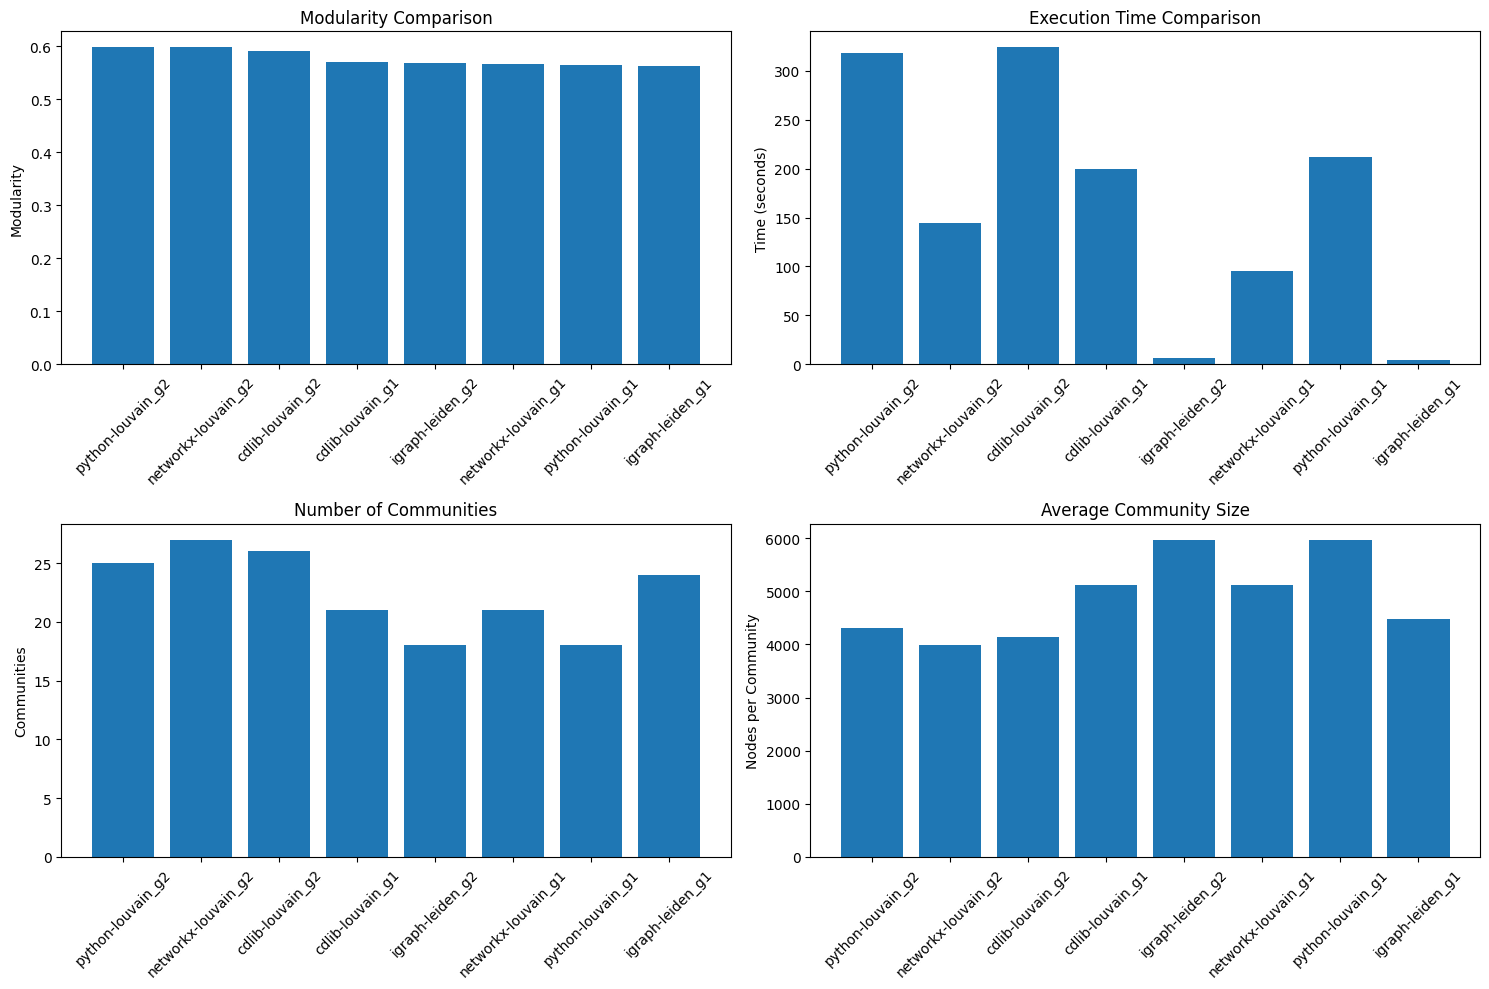


=== Community Size Distribution Analysis ===
python-louvain_g2:
  Range: 2 - 19203 nodes
  Mean ± Std: 4301.4 ± 5458.4
  Coefficient of variation: 1.27

networkx-louvain_g1:
  Range: 2 - 20833 nodes
  Mean ± Std: 5120.8 ± 5888.2
  Coefficient of variation: 1.15

networkx-louvain_g2:
  Range: 2 - 19830 nodes
  Mean ± Std: 3982.8 ± 5762.4
  Coefficient of variation: 1.45

igraph-leiden_g1:
  Range: 2 - 31607 nodes
  Mean ± Std: 4480.7 ± 7498.0
  Coefficient of variation: 1.67

igraph-leiden_g2:
  Range: 2 - 21295 nodes
  Mean ± Std: 5974.2 ± 5787.8
  Coefficient of variation: 0.97

python-louvain_g1:
  Range: 2 - 20006 nodes
  Mean ± Std: 5974.2 ± 6460.5
  Coefficient of variation: 1.08

cdlib-louvain_g1:
  Range: 2 - 21672 nodes
  Mean ± Std: 5120.8 ± 6563.1
  Coefficient of variation: 1.28

cdlib-louvain_g2:
  Range: 2 - 19658 nodes
  Mean ± Std: 4136.0 ± 5939.0
  Coefficient of variation: 1.44



In [26]:
# Create comprehensive comparison table
comparison_df = pd.DataFrame(results_comparison).T

# Sort by modularity (descending)
comparison_df = comparison_df.sort_values('modularity', ascending=False)

print("=== Implementation Comparison ===")
print(comparison_df.round(4))

# Detailed analysis
print("\n=== Performance Analysis ===")
print("Best modularity:", comparison_df['modularity'].max())
print("Fastest execution:", comparison_df['execution_time'].min(), "seconds")
print("Most communities:", comparison_df['num_communities'].max())
print("Fewest communities:", comparison_df['num_communities'].min())

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Modularity comparison
axes[0, 0].bar(comparison_df.index, comparison_df['modularity'])
axes[0, 0].set_title('Modularity Comparison')
axes[0, 0].set_ylabel('Modularity')
axes[0, 0].tick_params(axis='x', rotation=45)

# Execution time comparison
axes[0, 1].bar(comparison_df.index, comparison_df['execution_time'])
axes[0, 1].set_title('Execution Time Comparison')
axes[0, 1].set_ylabel('Time (seconds)')
axes[0, 1].tick_params(axis='x', rotation=45)

# Number of communities
axes[1, 0].bar(comparison_df.index, comparison_df['num_communities'])
axes[1, 0].set_title('Number of Communities')
axes[1, 0].set_ylabel('Communities')
axes[1, 0].tick_params(axis='x', rotation=45)

# Average community size
axes[1, 1].bar(comparison_df.index, comparison_df['avg_community_size'])
axes[1, 1].set_title('Average Community Size')
axes[1, 1].set_ylabel('Nodes per Community')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Community size distribution analysis
print("\n=== Community Size Distribution Analysis ===")
for alg, metrics in results_comparison.items():
    print(f"{alg}:")
    print(f"  Range: {metrics['smallest_community']} - {metrics['largest_community']} nodes")
    print(f"  Mean ± Std: {metrics['avg_community_size']:.1f} ± {metrics['std_community_size']:.1f}")
    
    # Calculate size variation coefficient
    cv = metrics['std_community_size'] / metrics['avg_community_size'] if metrics['avg_community_size'] > 0 else 0
    print(f"  Coefficient of variation: {cv:.2f}")
    print()

## Practical Recommendations & Integration Guidance

### Algorithm Selection Guide

**Choose based on your priorities:**

1. **`python-louvain` (community)** - **RECOMMENDED FOR MOST CASES**
   - ✅ **Pros**: Fast, well-tested, simple API, widely used
   - ✅ **Best for**: General purpose, reproducible research, quick prototyping
   - ⚠️ **Cons**: Limited advanced features
   - 📦 **Install**: `pip install python-louvain`

2. **`NetworkX Louvain`** - **GOOD FOR NETWORKX ECOSYSTEM**
   - ✅ **Pros**: Integrated with NetworkX, consistent API, no extra dependencies
   - ✅ **Best for**: Small-medium graphs, when already using NetworkX heavily
   - ⚠️ **Cons**: Slower than specialized implementations
   - 📦 **Install**: Built into NetworkX >= 2.5

3. **`igraph Leiden`** - **BEST FOR PERFORMANCE**
   - ✅ **Pros**: Extremely fast (C implementation), memory efficient, rich features
   - ✅ **Best for**: Large graphs, production systems, performance-critical applications
   - ⚠️ **Cons**: Additional dependency, different API style
   - 📦 **Install**: `pip install python-igraph`

4. **`CDlib`** - **BEST FOR RESEARCH & EVALUATION**
   - ✅ **Pros**: Multiple algorithms, comprehensive evaluation metrics, standardized format
   - ✅ **Best for**: Research, algorithm comparison, detailed analysis
   - ⚠️ **Cons**: Heavier dependency, slower than specialized implementations
   - 📦 **Install**: `pip install cdlib`

### Pipeline Integration Strategies

**For Production Systems:**
- Use `igraph` for speed and memory efficiency
- Implement caching for repeated runs
- Consider parallel processing for multiple graphs

**For Research & Analysis:**
- Use `CDlib` for comprehensive evaluation
- Compare multiple algorithms systematically
- Document parameter sensitivity

**For General Data Science:**
- Use `python-louvain` as default
- Switch to `igraph` if performance becomes an issue
- Use `NetworkX` if graph preprocessing is extensive

In [ ]:
# Production-Ready Integration Examples

class CommunityDetectionPipeline:
    """
    Production-ready community detection pipeline with multiple algorithms.
    """
    
    def __init__(self, algorithm='python-louvain', **kwargs):
        """
        Initialize pipeline with chosen algorithm.
        
        Parameters:
        - algorithm: 'python-louvain', 'networkx', 'igraph', 'cdlib-louvain', 'cdlib-leiden'
        - **kwargs: Algorithm-specific parameters
        """
        self.algorithm = algorithm
        self.params = kwargs
        self.results = {}
        
    def detect_communities(self, graph):
        """Run community detection with error handling and logging."""
        try:
            if self.algorithm == 'python-louvain':
                return self._run_python_louvain(graph)
            elif self.algorithm == 'networkx':
                return self._run_networkx(graph)
            elif self.algorithm == 'igraph':
                return self._run_igraph(graph)
            elif self.algorithm.startswith('cdlib'):
                method = self.algorithm.split('-')[1]
                return self._run_cdlib(graph, method)
            else:
                raise ValueError(f"Unknown algorithm: {self.algorithm}")
                
        except Exception as e:
            print(f"Error in community detection: {e}")
            return None, None, None
    
    def _run_python_louvain(self, graph):
        """Python-louvain implementation with caching."""
        resolution = self.params.get('resolution', 1.0)
        partition = community_louvain.best_partition(graph, resolution=resolution)
        modularity = community_louvain.modularity(partition, graph)
        
        # Calculate additional metrics
        communities = defaultdict(list)
        for node, comm_id in partition.items():
            communities[comm_id].append(node)
            
        metrics = {
            'num_communities': len(communities),
            'modularity': modularity,
            'algorithm': 'python-louvain'
        }
        
        return partition, modularity, metrics
    
    def _run_networkx(self, graph):
        """NetworkX implementation."""
        resolution = self.params.get('resolution', 1.0)
        communities = nx.community.louvain_communities(graph, resolution=resolution)
        
        partition = {}
        for comm_id, nodes in enumerate(communities):
            for node in nodes:
                partition[node] = comm_id
                
        modularity = nx.community.modularity(graph, communities)
        
        metrics = {
            'num_communities': len(communities),
            'modularity': modularity,
            'algorithm': 'networkx'
        }
        
        return partition, modularity, metrics
    
    def _run_igraph(self, graph):
        """igraph implementation with conversion."""
        # Convert to igraph (simplified version)
        nodes = list(graph.nodes())
        node_map = {node: i for i, node in enumerate(nodes)}
        edges = [(node_map[u], node_map[v]) for u, v in graph.edges()]
        
        g = ig.Graph(n=len(nodes), edges=edges)
        resolution = self.params.get('resolution', 1.0)
        communities = g.community_leiden(resolution_parameter=resolution)
        
        partition = {}
        for comm_id, node_indices in enumerate(communities):
            for node_idx in node_indices:
                partition[nodes[node_idx]] = comm_id
                
        metrics = {
            'num_communities': len(communities),
            'modularity': communities.modularity,
            'algorithm': 'igraph'
        }
        
        return partition, communities.modularity, metrics
    
    def _run_cdlib(self, graph, method):
        """CDlib implementation."""
        resolution = self.params.get('resolution', 1.0)
        
        if method == 'louvain':
            communities = algorithms.louvain(graph, resolution=resolution)
        elif method == 'leiden':
            communities = algorithms.leiden(graph, resolution_parameter=resolution)
        
        partition = {}
        for comm_id, nodes in enumerate(communities.communities):
            for node in nodes:
                partition[node] = comm_id
                
        modularity = evaluation.newman_girvan_modularity(graph, communities).score
        
        metrics = {
            'num_communities': len(communities.communities),
            'modularity': modularity,
            'algorithm': f'cdlib-{method}'
        }
        
        return partition, modularity, metrics

# Example usage of the pipeline
print("=== Production Pipeline Example ===")

# Test different algorithms
algorithms_to_test = [
    ('python-louvain', {'resolution': 1.0}),
    ('networkx', {'resolution': 1.0}),
    # ('igraph', {'resolution': 1.0}),  # Uncomment if igraph is available
]

pipeline_results = {}

for alg_name, params in algorithms_to_test:
    print(f"\nTesting {alg_name}...")
    
    pipeline = CommunityDetectionPipeline(algorithm=alg_name, **params)
    partition, modularity, metrics = pipeline.detect_communities(G_undirected)
    
    if partition is not None:
        pipeline_results[alg_name] = {
            'partition': partition,
            'modularity': modularity,
            'metrics': metrics
        }
        print(f"  ✓ Success: {metrics['num_communities']} communities, "
              f"modularity {modularity:.4f}")
    else:
        print(f"  ✗ Failed")

# Best practices for integration
print("\n=== Integration Best Practices ===")
print("""
1. **Error Handling**: Always wrap community detection in try-catch blocks
2. **Parameter Validation**: Validate resolution and other parameters
3. **Caching**: Cache results for expensive computations
4. **Logging**: Log algorithm choice, parameters, and results
5. **Fallback**: Have a fallback algorithm if primary fails
6. **Testing**: Test with different graph sizes and structures
7. **Documentation**: Document parameter choices and their effects
""")

## Parameter Tuning & Advanced Evaluation

### Resolution Parameter Analysis

The resolution parameter is crucial for controlling community granularity. Let's systematically explore its effects.

In [ ]:
# Systematic resolution parameter analysis
def resolution_analysis(graph, resolutions=None, algorithm='python-louvain'):
    """
    Analyze the effect of resolution parameter on community structure.
    """
    if resolutions is None:
        resolutions = [0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0]
    
    results = []
    
    for res in resolutions:
        if algorithm == 'python-louvain':
            partition = community_louvain.best_partition(graph, resolution=res)
            modularity = community_louvain.modularity(partition, graph)
        elif algorithm == 'networkx':
            communities = nx.community.louvain_communities(graph, resolution=res)
            modularity = nx.community.modularity(graph, communities)
            partition = {}
            for i, comm in enumerate(communities):
                for node in comm:
                    partition[node] = i
        
        # Calculate community statistics
        community_counts = defaultdict(int)
        for comm_id in partition.values():
            community_counts[comm_id] += 1
            
        num_communities = len(community_counts)
        community_sizes = list(community_counts.values())
        
        results.append({
            'resolution': res,
            'num_communities': num_communities,
            'modularity': modularity,
            'largest_community': max(community_sizes) if community_sizes else 0,
            'smallest_community': min(community_sizes) if community_sizes else 0,
            'avg_community_size': np.mean(community_sizes) if community_sizes else 0,
            'std_community_size': np.std(community_sizes) if community_sizes else 0
        })
    
    return pd.DataFrame(results)

# Run resolution analysis
print("=== Resolution Parameter Analysis ===")
resolution_df = resolution_analysis(G_undirected, algorithm='python-louvain')
print(resolution_df.round(3))

# Visualize resolution effects
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Number of communities vs resolution
axes[0, 0].plot(resolution_df['resolution'], resolution_df['num_communities'], 'bo-')
axes[0, 0].set_xlabel('Resolution Parameter')
axes[0, 0].set_ylabel('Number of Communities')
axes[0, 0].set_title('Communities vs Resolution')
axes[0, 0].grid(True)

# Modularity vs resolution
axes[0, 1].plot(resolution_df['resolution'], resolution_df['modularity'], 'ro-')
axes[0, 1].set_xlabel('Resolution Parameter')
axes[0, 1].set_ylabel('Modularity')
axes[0, 1].set_title('Modularity vs Resolution')
axes[0, 1].grid(True)

# Community size statistics
axes[1, 0].plot(resolution_df['resolution'], resolution_df['avg_community_size'], 'go-', label='Average')
axes[1, 0].fill_between(resolution_df['resolution'], 
                       resolution_df['avg_community_size'] - resolution_df['std_community_size'],
                       resolution_df['avg_community_size'] + resolution_df['std_community_size'],
                       alpha=0.3, color='green')
axes[1, 0].set_xlabel('Resolution Parameter')
axes[1, 0].set_ylabel('Community Size')
axes[1, 0].set_title('Average Community Size vs Resolution')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Size range
axes[1, 1].plot(resolution_df['resolution'], resolution_df['largest_community'], 'mo-', label='Largest')
axes[1, 1].plot(resolution_df['resolution'], resolution_df['smallest_community'], 'co-', label='Smallest')
axes[1, 1].set_xlabel('Resolution Parameter')
axes[1, 1].set_ylabel('Community Size')
axes[1, 1].set_title('Community Size Range vs Resolution')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Find optimal resolution based on different criteria
print("\n=== Optimal Resolution Selection ===")

# Method 1: Maximum modularity
max_modularity_idx = resolution_df['modularity'].idxmax()
optimal_res_modularity = resolution_df.loc[max_modularity_idx, 'resolution']
print(f"Resolution for maximum modularity: {optimal_res_modularity} "
      f"(modularity: {resolution_df.loc[max_modularity_idx, 'modularity']:.4f})")

# Method 2: Balanced number of communities (not too many, not too few)
# Rule of thumb: sqrt(n) communities for n nodes
target_communities = int(np.sqrt(G_undirected.number_of_nodes()))
closest_idx = (resolution_df['num_communities'] - target_communities).abs().idxmin()
optimal_res_balanced = resolution_df.loc[closest_idx, 'resolution']
print(f"Resolution for ~sqrt(n) communities: {optimal_res_balanced} "
      f"({resolution_df.loc[closest_idx, 'num_communities']} communities, target: {target_communities})")

# Method 3: Stable resolution (where modularity plateaus)
modularity_diff = resolution_df['modularity'].diff().abs()
stable_regions = modularity_diff < 0.01  # Small changes in modularity
if stable_regions.any():
    stable_idx = resolution_df[stable_regions].index[0]
    optimal_res_stable = resolution_df.loc[stable_idx, 'resolution']
    print(f"Resolution for stable modularity: {optimal_res_stable}")

print(f"\nRecommendation: Start with resolution = {optimal_res_modularity} for maximum modularity")
print(f"Alternative: Use resolution = {optimal_res_balanced} for balanced community sizes")

## Summary & Next Steps

### Key Takeaways

1. **Multiple robust implementations** of Louvain are available, each with different strengths
2. **Resolution parameter** is critical for controlling community granularity
3. **Performance varies significantly** between implementations
4. **Evaluation metrics** beyond modularity provide deeper insights

### Implementation Summary

| Library | Best For | Speed | Features | Recommendation |
|---------|----------|-------|----------|----------------|
| **python-louvain** | General use | Fast | Simple, reliable | ⭐ **Start here** |
| **NetworkX** | Small graphs | Medium | Integrated ecosystem | Good for prototyping |
| **igraph** | Large graphs | Very fast | Rich features | Production systems |
| **CDlib** | Research | Slow | Comprehensive metrics | Algorithm comparison |

### Next Steps

1. **Choose your primary implementation** based on your use case
2. **Tune the resolution parameter** using the analysis above
3. **Implement validation** using multiple metrics (modularity, conductance, etc.)
4. **Consider ensemble approaches** combining multiple algorithms
5. **Evaluate on your specific domain** - community quality is domain-dependent

### Production Checklist

- [ ] Choose algorithm based on graph size and performance requirements
- [ ] Implement error handling and fallback strategies
- [ ] Set up parameter validation and logging
- [ ] Add comprehensive evaluation metrics
- [ ] Test with representative data
- [ ] Document parameter choices and rationale
- [ ] Consider caching for repeated analyses
- [ ] Plan for scalability as data grows

**Ready to integrate into your larger pipeline!** 🚀